## Read the files and store content in a dictionary

In [1]:
import os, glob
from io import open

In [2]:
## Store the file locations in a list calles files

files = glob.glob('./dataset/surnames/names/*.txt')

In [3]:
country_names = {}

for file in files:
    country = os.path.basename(file).split(".")[0]
    names = open(file,'r',encoding='UTF-8').read().split('\n')
    
    country_names[country] = names

In [4]:
#country_names

### Check for Unicode characters and convert to ASCII

In [5]:
import unicodedata,string

In [6]:
ascii_letters = string.ascii_letters+" .,;''"

In [7]:
## Unicode Character categories : https://www.fileformat.info/info/unicode/category/index.htm
## Mn = Mark, Nonspacing

def convert_to_ascii(word):
    return "".join(letter for letter in unicodedata.normalize("NFD",word) if letter in ascii_letters and unicodedata.category(letter)!="Mn")

In [8]:
for country,names in country_names.items():
    country_names[country] = [convert_to_ascii(name) for name in names]

## Helper function to get samples from dictionary

In [9]:
import random

In [10]:
def get_sample_name():
    country = random.choice(list(country_names.keys()))
    countries = country_names[country]
    name = countries[random.randint(0,len(countries)-2)] #-2 because lat value in the list is empty
    
    ## name = random.choice(country_names[country])
    ## The above function, sometimes returns blank values
    
    return country,name
    
    

In [11]:
get_sample_name()

('Vietnamese', 'Hoang')

## Helper function to convert string to tensors

In [12]:
import torch

In [13]:
def get_letter_tensor(letter):    
    tnsr = torch.zeros((1,len(ascii_letters)))
    tnsr[:,ascii_letters.index(letter)]=1
    return tnsr
    

In [14]:
def get_word_tensor(word):

    word_tnsr = torch.zeros(len(word),1,len(ascii_letters))

    for i,letter in enumerate(word):
        word_tnsr[i,:,:]=get_letter_tensor(letter)
        
    return word_tnsr

In [15]:
all_categories=list(country_names.keys())
def get_cat_tensor(category):
    return torch.tensor([all_categories.index(category)],dtype=torch.long)

##  A  neural network - RNN 

In [16]:
import torch.nn as nn

In [17]:
class RNN(nn.Module):
    
    def __init__(self,input_size, hidden_size,output_size):
        
        super(RNN,self).__init__()
        
        self.hidden_size=hidden_size
        self.output_calc = nn.Linear(input_size+hidden_size,output_size)
        self.hidden_calc = nn.Linear(input_size+hidden_size,hidden_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self,input,hidden):
        combo = torch.cat((input,hidden),axis=1)
        
        hidden_layer = self.hidden_calc(combo)
        output_layer = self.output_calc(combo)
        
        output_layer = self.softmax(output_layer)
        
        return output_layer,hidden_layer
    
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)
        

In [18]:
hidden_size = 128
rnn = RNN(len(ascii_letters),hidden_size,len(country_names.keys()))

In [19]:
rnn.parameters

<bound method Module.parameters of RNN(
  (output_calc): Linear(in_features=186, out_features=18, bias=True)
  (hidden_calc): Linear(in_features=186, out_features=128, bias=True)
  (softmax): LogSoftmax()
)>

## Function to train single example

In [20]:
criterion = nn.NLLLoss()


In [21]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(country_tnsr, word_tnsr):
    hidden = rnn.initHidden()


    rnn.zero_grad()

    for i in range(word_tnsr.size()[0]):
        output, hidden = rnn(word_tnsr[i], hidden)
        

    loss = criterion(output, country_tnsr)
    loss.backward()

    # Update parameters
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

## Train the network on 1000s of examples

In [22]:
import time
import math

In [23]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [24]:
n_iters = 100_000
print_every = 5000
plot_every = 1000


In [26]:

current_loss = 0
all_losses = []


for iter in range(1, n_iters + 1):
    ## Get random pair of name & country and convert them into tensors.
    country,name = get_sample_name()
    country_tnsr,name_tnsr= (get_cat_tensor(country),get_word_tensor(name))
    
    output, loss = train(country_tnsr, name_tnsr)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == country else '✗ (%s)' % country
        print('%d %d%% %.4f %s / %s %s' % (iter, iter / n_iters * 100, loss, name, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% 1.7969 Said / Arabic ✓
10000 10% 1.4433 Lee / Chinese ✗ (Korean)
15000 15% 3.3025 Broz / Spanish ✗ (Polish)
20000 20% 1.9183 Chin / Korean ✗ (Chinese)
25000 25% 2.3326 Gale / Irish ✗ (English)
30000 30% 0.2939 Nishiwaki / Japanese ✓
35000 35% 2.2776 Winograd / Portuguese ✗ (Polish)
40000 40% 2.2625 Collins / Greek ✗ (Irish)
45000 45% 0.3873 Davidson / Scottish ✓
50000 50% 0.4697 Mcdonald / Scottish ✓
55000 55% 3.0164 Michel / Irish ✗ (Spanish)
60000 60% 0.9304 Hofer / German ✓
65000 65% 0.0534 Ieyasu / Japanese ✓
70000 70% 1.3523 Sala / Spanish ✓
75000 75% 2.3222 Mcneil / Scottish ✗ (Irish)
80000 80% 3.1563 Rompa / Czech ✗ (Dutch)
85000 85% 0.5082 Close / Greek ✓
90000 90% 0.2172 Okura / Japanese ✓
95000 95% 1.7877 Ferrer / German ✗ (Spanish)
100000 100% 0.0545 Aswad / Arabic ✓


## Evaluating the Results

In [27]:
all_losses[:10]

[2.4127648069262504,
 2.3720688259005547,
 2.3565304247140886,
 2.2769060034155846,
 2.242711704492569,
 2.169371742576361,
 2.0899487034007906,
 2.0738369342908265,
 2.04033457197994,
 2.0244275058209897]

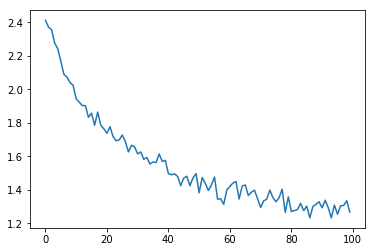

In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [29]:
## Output for a given word

def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

### Testing new values

In [30]:
categoryFromOutput(evaluate(get_word_tensor('Dovesky')))

('Russian', 6)

In [31]:
categoryFromOutput(evaluate(get_word_tensor('Jackson')))

('Scottish', 14)